In [1]:
import sys
import numpy as np
import pandas as pd
import networkx as nx
import geopandas as gpd
from pathlib import Path
from itertools import product
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from shapely.ops import unary_union

sys.path.append(str(Path.cwd()))
sys.path.append(str(Path.cwd().parent/'scripts'))

from _helpers import generate_color_list
from industry_cluster_analysis import (
    get_costoptimal_network,
    get_simple_costoptimal_network,
    get_partitions,
    plot_network,
    get_plant_capex,
    get_heat_network,
    coords_to_relative_utm,
)

Empty DataFrame
Columns: [source, target]
Index: []


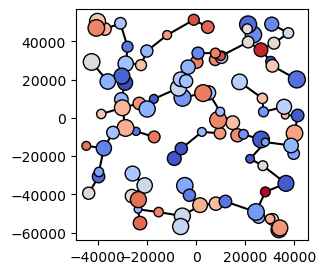

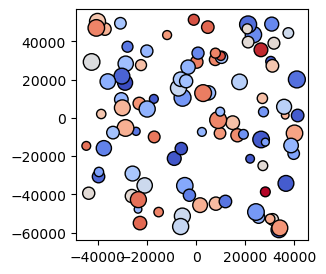

0 670011.7897249087


In [2]:
n = 100
pipe_capex = 1000

sample_coords = np.hstack((
    np.random.uniform(-101, -100, (n, 1)),
    np.random.uniform(38, 39, (n, 1)),
))

sample_coords_meters = coords_to_relative_utm(sample_coords)

sample_temps = np.random.uniform(80, 250, n).tolist()
sample_caps = np.random.uniform(1, 5, n).tolist()

# sample_network, sample_cost = get_costoptimal_network(sample_coords, sample_temps, sample_caps)
T, sample_cost = get_simple_costoptimal_network(
    sample_coords_meters,
    pipe_capex=pipe_capex,
    # sample_temps,
    # sample_caps,
    )

base = nx.Graph()
for i, (x, y) in enumerate(sample_coords_meters):
    base.add_node(
        i,
        pos=(x, y),
        )


for i, j in product(range(n), range(n)):
    if i > j:
        base.add_edge(i, j, weight=np.linalg.norm(np.array(sample_coords_meters[i]) - np.array(sample_coords_meters[j])))

tree = nx.minimum_spanning_tree(base, weight='weight', algorithm='kruskal')

salesman = nx.Graph()
# for i, (x, y) in enumerate(sample_coords):
for i, (x, y) in enumerate(sample_coords_meters):
    salesman.add_node(
        i,
        pos=(x, y),
        )

edgelist = nx.to_pandas_edgelist(T)
print(edgelist)

for i, j in edgelist[['source', 'target']].values:
    # length = V_inv(np.array(sample_coords[i]), np.array(sample_coords[j]))[0]
    salesman.add_edge(i, j, weight=np.linalg.norm(np.array(sample_coords_meters[i]) - np.array(sample_coords_meters[j])))
        # 4 because there is a hot and cold cycle

    # T = nx.minimum_spanning_tree(G, weight='weight', algorithm='kruskal')
plot_network(tree, sample_coords_meters, sample_caps, sample_temps)
plot_network(salesman, sample_coords_meters, sample_caps, sample_temps)

total_length_salesman = 0
for i, j in salesman.edges:
    total_length_salesman += np.linalg.norm(np.array(sample_coords_meters[i]) - np.array(sample_coords_meters[j]))

total_length_tree = 0
for i, j in tree.edges:
    total_length_tree += np.linalg.norm(np.array(sample_coords_meters[i]) - np.array(sample_coords_meters[j]))


print(total_length_salesman, total_length_tree)

In [3]:
shape = gpd.read_file(Path.cwd() /
        'misc_data' /
        'zip_data' /
        'backup_copy' /
        'resources' /
        'US_2021' /
        'bus_regions' /
        'regions_onshore_elec_s_100flex.geojson' /
        'regions_onshore_elec_s_100flex.geojson'
        )

usa_total = gpd.GeoDataFrame(geometry=[unary_union(shape['geometry'])]).set_crs(shape.crs)

In [4]:
def get_dummy_data(do_plot=False):

    n = 500

    t_levels = [90 + i*5 for i in range(40)]

    sites = gpd.GeoDataFrame(
        {
            'demand': np.random.uniform(1, 10, n),
            'temperature': np.random.choice(t_levels, n, replace=True)
            },
        geometry=gpd.points_from_xy(
            # np.random.uniform(-130, -60, 1000),
            # np.random.uniform(25, 50, 1000)
            np.random.uniform(-130, -120, n),
            np.random.uniform(40, 45, n)
            )
        ).set_crs(epsg=4326)

    sites['demand'] *= 50_000

    sites = sites.sjoin(shape, how='inner')

    if do_plot:

        fig, ax = plt.subplots(figsize=(7, 7))

        shape.plot(ax=ax)
        sites.plot(
            ax=ax,
            # color='red',
            column='temperature',
            cmap='magma',
            edgecolor='black',
            markersize=40
            )

        cax = fig.add_axes([0.9, 0.1, 0.03, 0.78])

        norm = plt.Normalize(vmin=sites['temperature'].min(), vmax=sites['temperature'].max())
        sm = plt.cm.ScalarMappable(cmap='magma', norm=norm)
        fig.colorbar(sm, cax=cax)
        cax.set_ylabel('Temperature (°C)')

        ax.set_xlim(-127, -118)
        ax.set_ylim(39, 46)

        plt.show()

    return sites

In [55]:
def get_india_data():

    # df = gpd.read_file('overture_places_heating_demand_disagg_20241008.gpkg')
    df = gpd.read_file('overture_places_heating_demand_disagg_wp_filtered_20241020.gpkg')

    id_cols = [
        'names_primary', 'geometry',
        'industrial_type', 'industrial_sub_type'
    ]

    heating_cols = [
        col for col in df.columns
        if 'Heating (BBtu)' in col and 'total' not in col and '<250' not in col
    ]

    # Melt the dataframe to unpivot heating columns
    df_melted = df.melt(
        id_vars=id_cols,
        value_vars=heating_cols,
        var_name='Temperature Range',
        value_name='Heating Demand (BBtu)'
    )

    # Keep only rows with non-zero heating demand
    df_melted = df_melted[df_melted['Heating Demand (BBtu)'] != 0]

    # Clean up the 'Temperature Range' column
    df_melted['Temperature Range'] = df_melted['Temperature Range'].str.replace(
        'Heating (BBtu), ', '', regex=False
    )

    # Convert BBtu to MWh (1 BBtu = 293.07107 MWh)
    df_melted['Heating Demand (MWh)'] = df_melted['Heating Demand (BBtu)'] * 293.07107

    # Optionally drop the original 'Heating Demand (BBtu)' column
    df_melted = df_melted.drop(columns=['Heating Demand (BBtu)'])

    # Reorder columns if necessary
    df_melted = df_melted[
        id_cols + ['Temperature Range', 'Heating Demand (MWh)']
    ]

    # Cut off rows with heating demand above a certain threshold 
    cutoff = 5000 # MWh; cutoff of 5GWh removes around 1% of total demand, and 50% of datapoints
    df_melted = df_melted.loc[df_melted['Heating Demand (MWh)'] > cutoff]

    df_melted = df_melted.reset_index(drop=True)

    temp_mapper = {
        '0 to 49°C': 50,
        '50 to 99°C': 100,
        '100 to 149°C': 150,
        '150 to 199°C': 200,
        '200 to 249°C': 250,
        '250 to 299°C': 300,
        '300 to 349°C': 350,
        '350 to 399°C': 400,
        '400 to 449°C': 450,
        '>450°C': 500,
    }

    for old, new in temp_mapper.items():
        df_melted.replace(old, new, inplace=True)
    df_melted.rename(columns={
        'Temperature Range': 'temperature',
        'Heating Demand (MWh)': 'total_demand',
        }, inplace=True)
    df_melted['avg_demand'] = df_melted['total_demand'] / 8760

    df_melted = df_melted.loc[df_melted['temperature'] < 400]

    df_melted['x'] = df_melted['geometry'].x
    df_melted['y'] = df_melted['geometry'].y

    return df_melted


In [56]:
# get_dummy_data().columns
sites = get_india_data()

C:\Users\lukas\AppData\Local\Temp\ipykernel_46752\3132361217.py:63: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_melted.replace(old, new, inplace=True)


In [57]:
sites.sort_values('avg_demand', ascending=False)
print(sites.shape)
sites.loc[sites['avg_demand'] > 10].shape

(2031, 9)


(371, 9)

In [58]:
def round_borehole_capex(cap, one_drill_cap, one_drill_capex):

    fraction = cap / one_drill_cap
    n_wells = round(fraction)

    return one_drill_capex * max(n_wells, fraction) / min(n_wells, fraction)

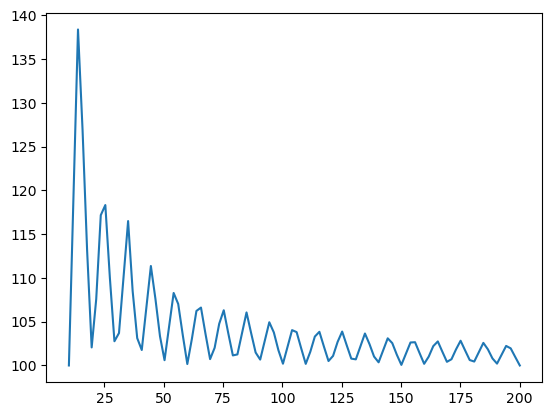

In [59]:
caps = np.linspace(10, 200, 100)

plt.plot(
    caps,
    [round_borehole_capex(cap, 10, 100) for cap in caps]
    )


In [60]:
countries = gpd.read_file('country_shapes.geojson').set_index('cntry_name').loc[[
    'India',
    'Pakistan',
    'Bangladesh',
    'Bhutan',
    'China',
    'Sri Lanka'
    ]]

In [61]:
import tqdm

# from shapely.geometry import MultiPoint
# from sklearn.metrics.pairwise import haversine_distances


threshold_distance_km = 15
threshold_distance_rad = threshold_distance_km / 6371.0

network_capacity_threshold = 10 # MWth
one_drill_capex = 9_200_000 / network_capacity_threshold


# sites = get_dummy_data()

# for index_right in sites.index_right.value_counts().index:
def cluster_sites(
        sites,
        pipe_capex_value=1500,
        do_plot=False
        ):

    # ss = sites.loc[sites.index_right == index_right]
    ss = sites.copy()

    sites_np = np.array([ss['geometry'].y, ss['geometry'].x]).T

    db = DBSCAN(
        eps=threshold_distance_rad,
        min_samples=2,
        metric='haversine').fit(np.radians(sites_np))
        # metric='haversine').fit(np.radians(sites_np_meters))
        # ).fit(np.radians(sites_np_meters))

    labels = db.labels_

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    sites['cluster'] = labels
    sites['cluster_size'] = list(map(pd.Series(labels).value_counts().get, labels))

    max_cluster_size = 5
    
    # if max_cluster_size is not None:
    #     sites = sites.loc[
    #         (sites.cluster == -1) |
    #         (sites.cluster_size <= max_cluster_size)
    #     ]
    # print(sites.cluster.value_counts())
    # print(sites.cluster_size.sort_values())

    if do_plot:
        _, ax = plt.subplots(1, 1, figsize=(10, 8))
    # shape.plot(ax=ax)

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    caps, capex, cluster_size = [], [], []

    for k, col in tqdm.tqdm(zip(unique_labels, colors)):

        # print(k)

        class_member_mask = (labels == k)
        # print(class_member_mask.sum())

        if max_cluster_size is not None:
            if k != -1 and class_member_mask.sum() > max_cluster_size:
                continue

        xy = sites_np[class_member_mask]
        xy_meters = coords_to_relative_utm(xy)

        size = ss.iloc[class_member_mask]['avg_demand']
        temps = ss.iloc[class_member_mask]['temperature']

        if sum(size) < network_capacity_threshold:
            continue

        if k == -1:
            col = [0, 0, 0, 1]

            for s in size:
                if s < network_capacity_threshold:
                    continue
                else:

                    caps.append(s)
                    # capex.extend(get_plant_capex(np.array(size)))



                    plant_capex = (
                        round_borehole_capex(
                            s,
                            network_capacity_threshold,
                            one_drill_capex
                            )
                    )
                    capex.append(plant_capex)

                    # def round_borehole_capex(cap, one_drill_cap, one_drill_capex):
                    #  cluster_size.extend([1] * len(size))
                    cluster_size.append(1)

        else:
            partitions = get_partitions(list(range(len(xy))))
            partition_costs = []
            disagg_partition_costs = []

            partition_caps = []
            partition_cluster_sizes = []

            for i, partition in enumerate(partitions):

                n_cost = []
                n_caps = []
                n_cluster_size = []

                ineligible = False
                for n_idx in partition:
                    if sum(size.iloc[list(n_idx)]) < network_capacity_threshold:
                        ineligigle = True
                        break
                
                if ineligible:
                    continue

                # partition discarded if no monotonically decreasing
                # temperature levels are found
                partition_eligible = False 

                for n_idx in partition:

                    n_xy = xy[[n_idx]][0]
                    n_xy_meters = xy_meters[[n_idx]][0]
                    n_temp = temps.iloc[list(n_idx)].tolist()
                    n_size = size.iloc[list(n_idx)]
                    n_cluster_size.append(len(n_idx))

                    total_caps, total_cost = get_heat_network(n_xy, n_temp, n_size, pipe_capex=pipe_capex_value)
                    # _, total_cost = get_simple_costoptimal_network(n_xy_meters)

                    total_cost += round_borehole_capex(
                        sum(n_size),
                        network_capacity_threshold,
                        one_drill_capex
                        )

                    n_cost.append(total_cost)
                    n_caps.append(sum(n_size))

                partition_costs.append(sum(n_cost))
                disagg_partition_costs.append(n_cost)
                partition_caps.append(n_caps)
                partition_cluster_sizes.append(n_cluster_size)

            if not len(partition_caps):
                continue

            best_partition = partitions[np.argmin(partition_costs)]
            best_partition_caps = partition_caps[np.argmin(partition_costs)]
            best_disagg_partition_costs = disagg_partition_costs[np.argmin(partition_costs)]
            best_partition_cluster_sizes = partition_cluster_sizes[np.argmin(partition_costs)]

            for ca, co, cl in zip(
                best_partition_caps,
                best_disagg_partition_costs,
                best_partition_cluster_sizes
                ):

                caps.append(ca)
                capex.append(co)
                cluster_size.append(cl)

        if do_plot:
            ax.scatter(
                xy[:, 1],
                xy[:, 0],
                color=tuple(col),
                edgecolor='k',
                alpha=0.7,
                s=size*10*0.5
                )

    if do_plot:
        countries.plot(ax=ax, color='none', edgecolor='black', linewidth=1, zorder=0)
        countries.loc[['India']].plot(ax=ax, color='grey', edgecolor='black', linewidth=0, zorder=0, alpha=0.2)

        ax.set_title(f'Estimated number of clusters: {n_clusters}')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        # ax.set_xlim(xy[:, 1].min() - 0.1, xy[:, 1].max() + 0.1)
        # ax.set_ylim(xy[:, 0].min() - 0.1, xy[:, 0].max() + 0.1)

        ax.set_xlim(67, 97)
        ax.set_ylim(7.2, 35.1)

        plt.show()

    return pd.DataFrame({
        'caps': caps,
        'capex': capex,
        'cluster_size': cluster_size
        }).dropna()



80it [00:00, 163.73it/s]c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:563: RuntimeWarning: invalid value encountered in subtract
  relative_eastings = eastings - centroid_easting
c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:564: RuntimeWarning: invalid value encountered in subtract
  relative_northings = northings - centroid_northing
c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:563: RuntimeWarning: invalid value encountered in subtract
  relative_eastings = eastings - centroid_easting
c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:564: RuntimeWarning: invalid value encountered in subtract
  relative_northings = northings - centroid_northing
178it [00:01, 115.63it/s]c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:563: RuntimeWarning

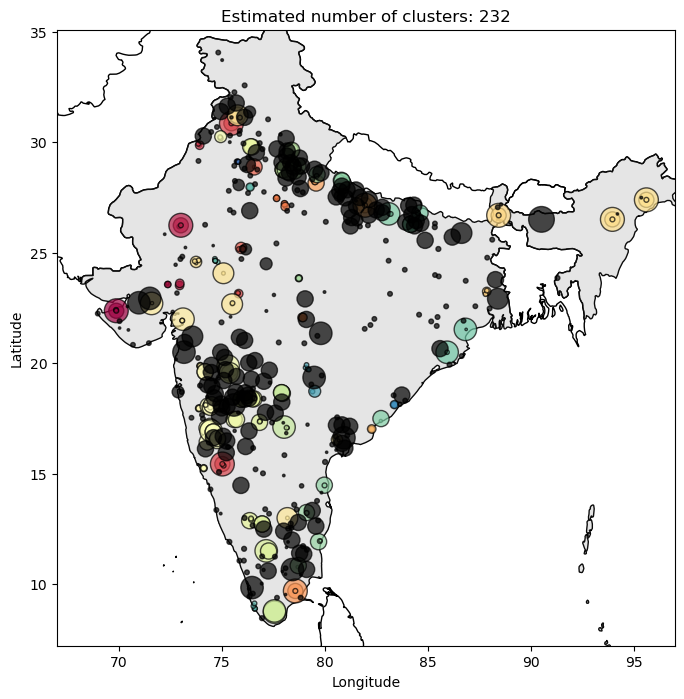

80it [00:00, 168.60it/s]c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:563: RuntimeWarning: invalid value encountered in subtract
  relative_eastings = eastings - centroid_easting
c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:564: RuntimeWarning: invalid value encountered in subtract
  relative_northings = northings - centroid_northing
c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:563: RuntimeWarning: invalid value encountered in subtract
  relative_eastings = eastings - centroid_easting
c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:564: RuntimeWarning: invalid value encountered in subtract
  relative_northings = northings - centroid_northing
180it [00:01, 102.33it/s]c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:563: RuntimeWarning

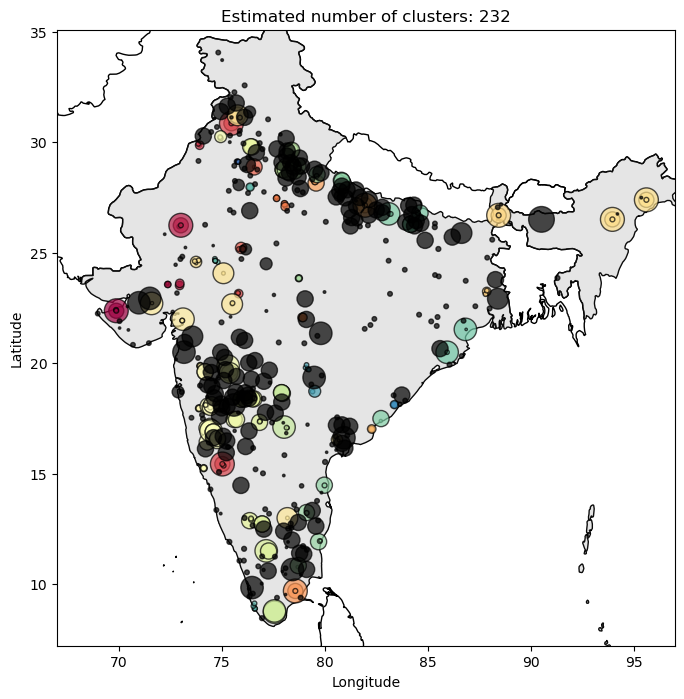

80it [00:00, 162.96it/s]c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:563: RuntimeWarning: invalid value encountered in subtract
  relative_eastings = eastings - centroid_easting
c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:564: RuntimeWarning: invalid value encountered in subtract
  relative_northings = northings - centroid_northing
c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:563: RuntimeWarning: invalid value encountered in subtract
  relative_eastings = eastings - centroid_easting
c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:564: RuntimeWarning: invalid value encountered in subtract
  relative_northings = northings - centroid_northing
180it [00:01, 118.62it/s]c:\Users\lukas\OneDrive\Desktop\projects\pis\pypsa-earth-sec\scripts\industry_cluster_analysis.py:563: RuntimeWarning

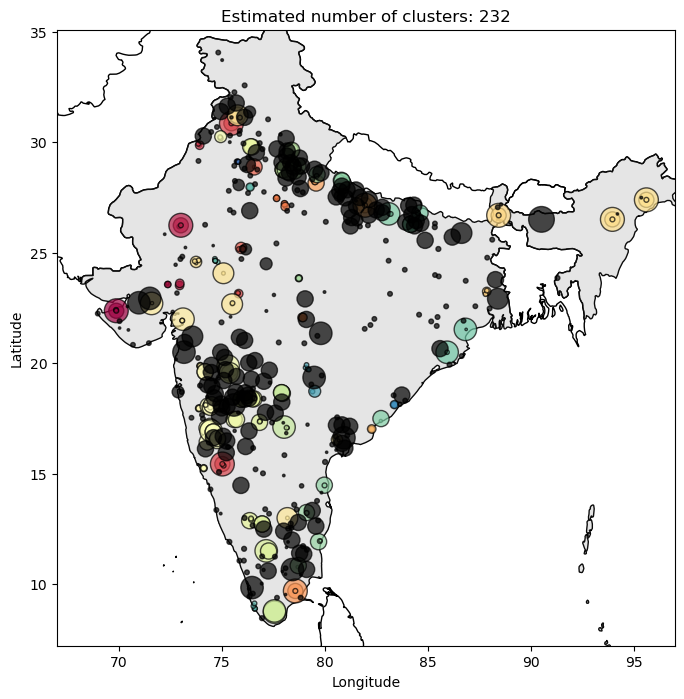

In [76]:
data = list()
for i, capex in enumerate([1000, 1500, 2000]):

    region_df = cluster_sites(sites, pipe_capex_value=capex, do_plot=True).sort_values('capex')
    data.append(region_df)

In [63]:
def generate_color_list(n):
    # Use a colormap to generate n distinct colors
    cmap = plt.get_cmap('Accent')
    colors = [cmap(i / n) for i in range(n)]
    return colors

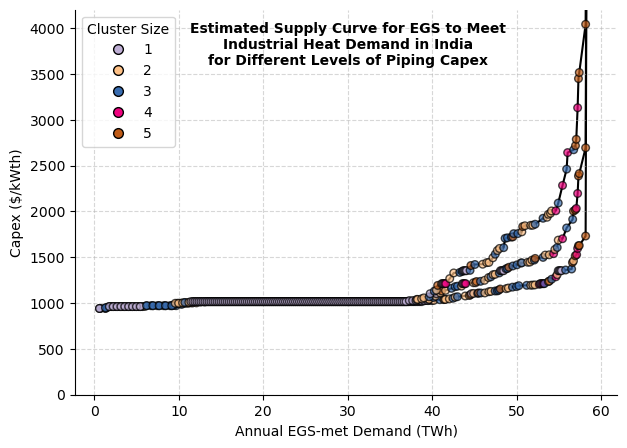

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))


for i, region_df in enumerate(data):

    # region_df = region_df.loc[region_df['cluster_size'] > 1]

    # region_df = cluster_sites(sites).sort_values('capex')
    region_df['cumcap'] = region_df['caps'].cumsum()


    ax.plot(region_df['cumcap']*8760*1e-6, region_df['capex']*1e-3, zorder=1, color='black')

    color_list = generate_color_list(max(region_df['cluster_size']) + 1)
    c = [color_list[i] for i in region_df['cluster_size']]

    ax.scatter(
        region_df['cumcap']*8760*1e-6,
        region_df['capex']*1e-3,
        c=c,
        s=30,
        edgecolor='k',
        zorder=2,
        alpha=0.7
        )
    ax.set_xlabel('Annual EGS-met Demand (TWh)')
    ax.set_ylabel('Capex ($/kWth)')

    # ax.set_xlim(-10, 770)
    # ax.set_ylim(500, 1040)

    ax.grid(True, linestyle='--', alpha=0.5)

    labels = region_df['cluster_size'].unique()
    handles = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_list[i], markersize=7,
                markeredgecolor='k', label=f'{i} sites')
            for i in labels]
    
    labels = pd.DataFrame({
        'labels': labels,
        'handles': handles
        }).sort_values('labels')

    if i == 0:
        ax.legend(labels['handles'], labels['labels'], title='Cluster Size', loc='upper left')

# ax.text()
# rotation=slope_1000,
# ax.text(18, 2000, '2000$/m', color='k', rotation=12, va='center', ha='center', fontweight='bold')
# ax.text(20, 1650, '1500$/m', color='k', rotation=10, va='center', ha='center', fontweight='bold')
# ax.text(22, 1100, '1000$/m', color='k', rotation=10, va='center', ha='center', fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.text(
    30, 3600,
    'Estimated Supply Curve for EGS to Meet\nIndustrial Heat Demand in India\nfor Different Levels of Piping Capex',
    fontsize=10,
    fontweight='bold',
    ha='center'
)

ax.set_ylim(0, 4200)
plt.show()

In [5]:

# Example usage
if __name__ == "__main__":
    # List of coordinates (longitude, latitude)
    coords = [
        (-122.4194, 37.7749),  # San Francisco
        (-118.2437, 34.0522),  # Los Angeles
        (-121.8863, 37.3382),  # San Jose
        (-117.1611, 32.7157),  # San Diego
        (-119.4179, 36.7783),  # California centroid
    ]

    relative_coords = coords_to_relative_utm(coords)

    # print(f"UTM Zone: {utm_zone}, Hemisphere: {hemisphere}")
    print("Coordinates relative to centroid (in meters):")
    for i, (rel_e, rel_n) in enumerate(relative_coords):
        print(f"Point {i + 1}: Easting: {rel_e:.2f} km, Northing: {rel_n:.2f} m")

Coordinates relative to centroid (in meters):
Point 1: Easting: -221873.95 km, Northing: 236804.51 m
Point 2: Easting: 140778.27 km, Northing: -189248.98 m
Point 3: Easting: -177405.93 km, Northing: 185713.84 m
Point 4: Easting: 240466.98 km, Northing: -338108.87 m
Point 5: Easting: 39787.84 km, Northing: 115115.31 m


In [3]:
relative_coords_km

array([[-221.87395136,  236.80450827],
       [ 140.77826783, -189.2489849 ],
       [-177.40592807,  185.71383613],
       [ 240.46697621, -338.10886675],
       [  39.78783927,  115.11531056]])

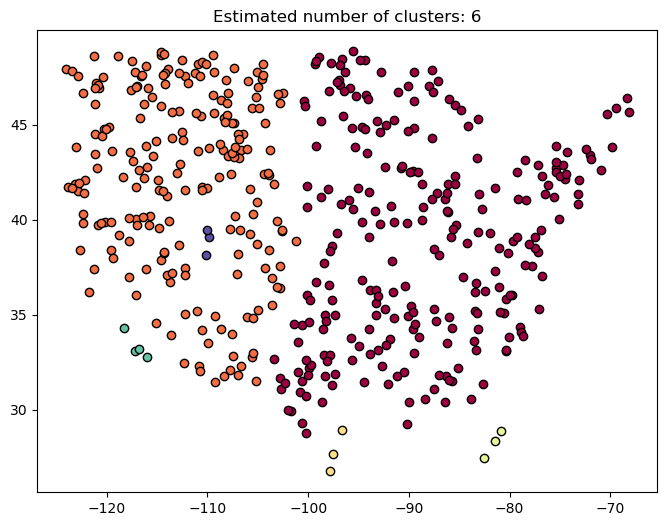

In [13]:
threshold_distance = 2

# Perform DBSCAN clustering
db = DBSCAN(eps=threshold_distance, min_samples=2).fit(sites_np)
labels = db.labels_


# Number of clusters (ignoring noise if any)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Plot the results
plt.figure(figsize=(8, 6))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    xy = sites_np[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

plt.title(f'Estimated number of clusters: {n_clusters}')
plt.show()


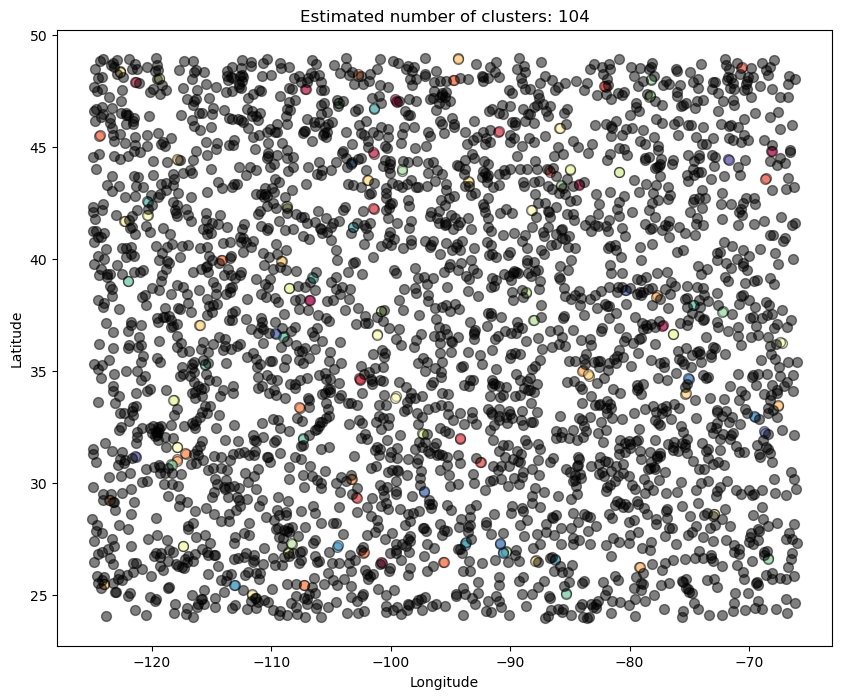

In [16]:
import numpy as np
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
import matplotlib.pyplot as plt

latitudes = np.random.uniform(low=24, high=49, size=3000)
longitudes = np.random.uniform(low=-125, high=-66, size=3000)
sites = np.vstack((latitudes, longitudes)).T

# Define the maximum distance for a cluster in kilometers
threshold_distance_km = 10

# Convert the threshold distance from kilometers to radians (for use with geodesic distance)
threshold_distance_rad = threshold_distance_km / 6371.0  # Earth's radius in km

# Perform DBSCAN clustering based on geographical distance
db = DBSCAN(eps=threshold_distance_rad, min_samples=2, metric='haversine').fit(np.radians(sites))
labels = db.labels_

# Number of clusters (ignoring noise if any)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Plotting the results (not geographically accurate but illustrative)
plt.figure(figsize=(10, 8))
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]  # Black for noise

    class_member_mask = (labels == k)
    xy = sites[class_member_mask]
    plt.scatter(xy[:, 1], xy[:, 0], color=tuple(col), edgecolor='k', s=50, alpha=0.5)

plt.title(f'Estimated number of clusters: {n_clusters}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


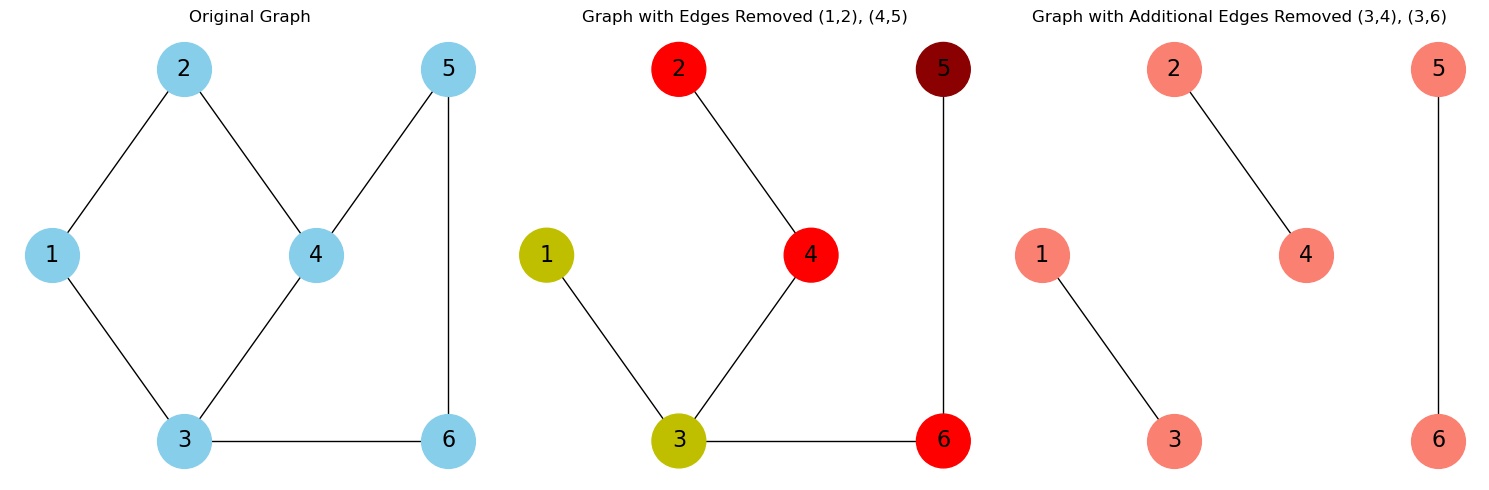

In [22]:
import matplotlib.pyplot as plt
import networkx as nx

# Create the initial graph
G = nx.Graph()

# Add nodes
nodes = [1, 2, 3, 4, 5, 6]
G.add_nodes_from(nodes)

# Add edges
edges = [(1, 2), (1, 3), (2, 4), (3, 4), (4, 5), (5, 6), (3, 6)]
G.add_edges_from(edges)

# Define fixed positions for the nodes
fixed_positions = {
    1: (0, 2),
    2: (1, 3),
    3: (1, 1),
    4: (2, 2),
    5: (3, 3),
    6: (3, 1)
}

# Plot 1: Original Graph
plt.figure(figsize=(15, 5))
plt.subplot(131)  # 1 row, 3 columns, 1st subplot
nx.draw(G, pos=fixed_positions, with_labels=True, node_color='skyblue', edge_color='black', node_size=1500, font_size=16)
plt.title("Original Graph")

# Plot 2: Remove some edges and plot
G2 = G.copy()
edges_to_remove_2 = [(1, 2), (4, 5)]
G2.remove_edges_from(edges_to_remove_2)

plt.subplot(132)  # 1 row, 3 columns, 2nd subplot
nx.draw(G2, pos=fixed_positions, with_labels=True, node_color=['y', 'r', 'y', 'r', 'darkred', 'r'], edge_color='black', node_size=1500, font_size=16)
plt.title("Graph with Edges Removed (1,2), (4,5)")

# Plot 3: Remove more edges and plot
G3 = G2.copy()
edges_to_remove_3 = [(3, 4), (3, 6)]
G3.remove_edges_from(edges_to_remove_3)

plt.subplot(133)  # 1 row, 3 columns, 3rd subplot
nx.draw(G3, pos=fixed_positions, with_labels=True, node_color='salmon', edge_color='black', node_size=1500, font_size=16)
plt.title("Graph with Additional Edges Removed (3,4), (3,6)")

# Show all plots
plt.tight_layout()
plt.show()


In [21]:
sys.path.append(str(Path.cwd()))

from vincenty import V_inv

ImportError: cannot import name 'V_inv' from 'vincenty' (unknown location)

In [26]:


get_plant_capex(800_000)

91.32420091324201


2433789.9543379

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))